# T2: analysis of preprocessed data

In [1]:
import matplotlib.pyplot as plt

from fibphot.analysis.auc import AUC
from fibphot.analysis.peaks import (
    PeakAnalysis,
    peak_result_to_dataframe,
    plot_peak_result,
)
from fibphot.analysis.plotting import plot_auc_result
from fibphot.analysis.report import AnalysisWindow, PhotometryReport
from fibphot.io import read_doric
from fibphot.stages import (
    DoubleExpBaseline,
    HampelFilter,
    IsosbesticRegression,
    LowPassFilter,
    Normalise,
    Trim,
)

%config InlineBackend.figure_format = "retina"

---
## Preprocess data

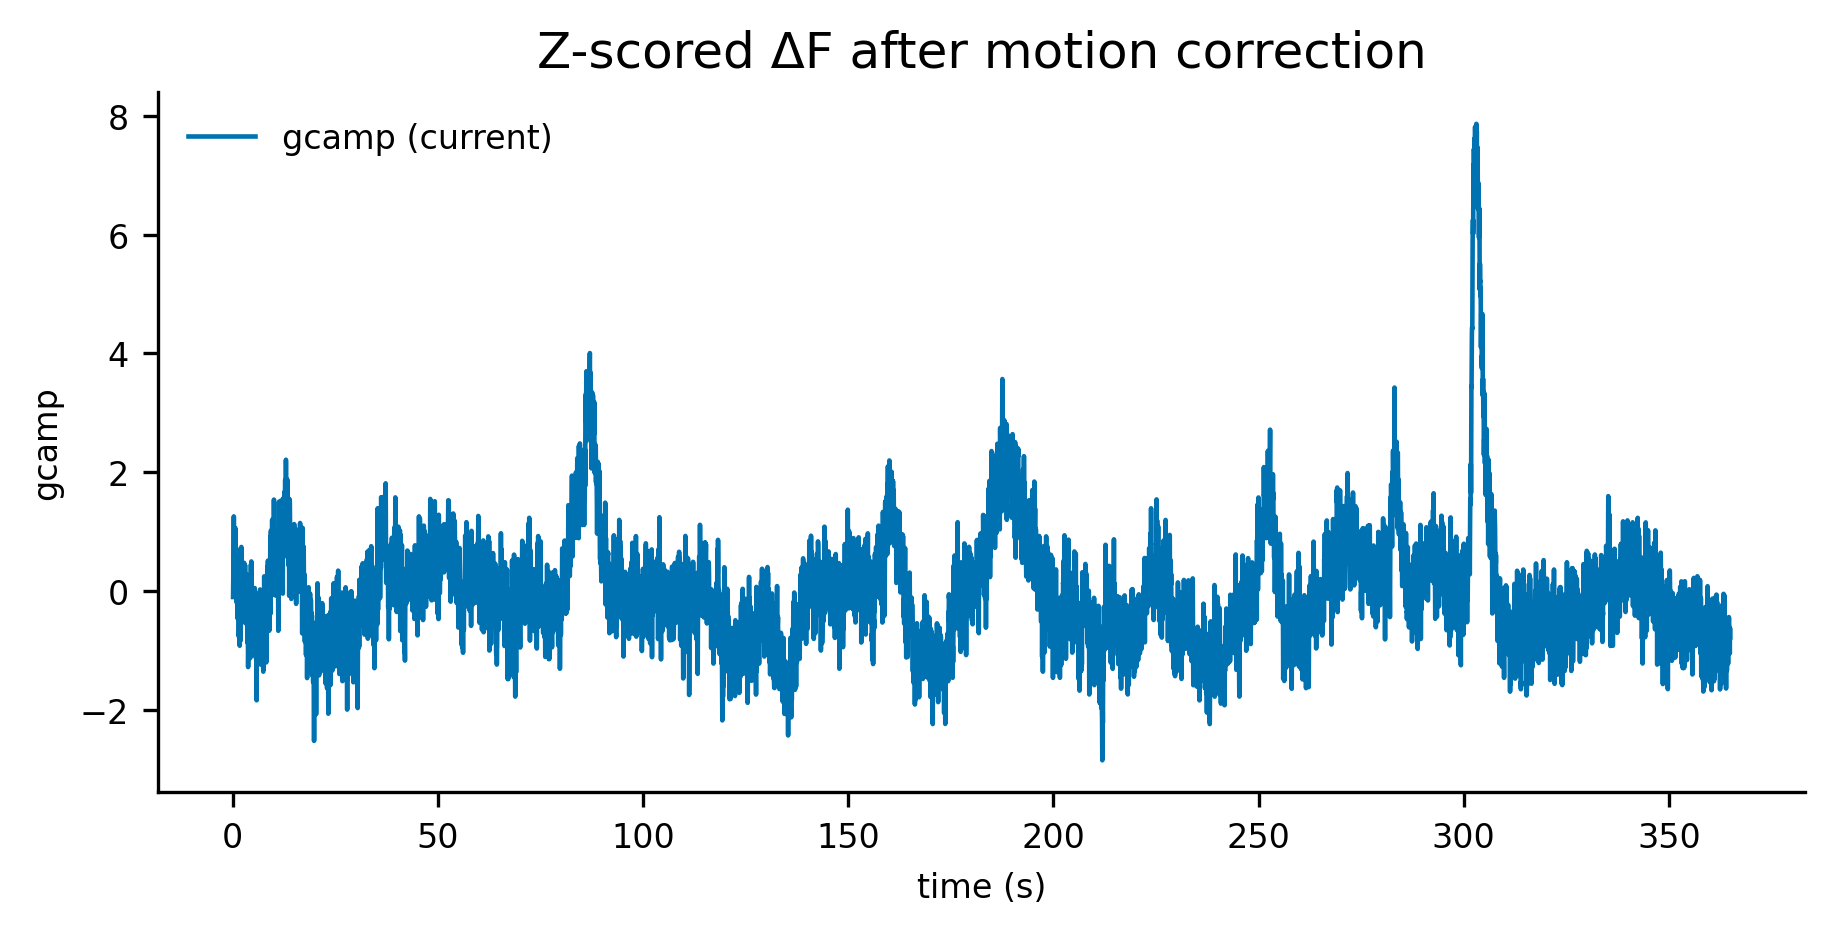

StageRecord(stage_id='0006_normalise', name='normalise', params={'method': 'z_score', 'channels': ['gcamp'], 'baseline_key': None, 'baseline_mode': 'percent', 'time_window': None, 'ddof': 0, 'null_z_scale': 'rms', 'mad_scale': 1.4826, 'eps': 1e-12}, metrics={}, notes=None)

In [ ]:
path: str = "" # TODO: set path to a Doric .doric file

state0 = read_doric(path)

state_final = state0.pipe(
    Trim(end=20.0, unit="seconds"),
    HampelFilter(window_size=13, n_sigmas=3.0, channels="all"),
    LowPassFilter(critical_frequency=10.0, order=2, channels="all"),
    DoubleExpBaseline(subtract=True, channels="all"),
    IsosbesticRegression(
        control="iso",
        channels=["gcamp"],
        method="irls_tukey",
        tuning_constant=1.4,
        store_weights=False,
    ),
    Normalise.z_score(channels=["gcamp"]),
)

fig, ax = state_final.plot(
    signal="gcamp",
    title="Z-scored ΔF after motion correction",
)
plt.show()

state_final.summary[-1]

We will store all results in a PhotometryReport ...

In [3]:
report = PhotometryReport(state_final)

---

## Area under the curve (AUC)

When we compute an “area under the curve” (AUC), we are integrating a signal
over time:

$$
\mathrm{AUC} = \int_{t_0}^{t_1} y(t)\,dt.
$$

In fibre photometry, this can be used as a summary of response magnitude within 
a window (e.g. around a cue or reward), or across an entire session. The 
**units** are “signal units × seconds” (for example, `%ΔF/F × s` or 
`z-score × s`).

There are two main choices to make:

1) **How to treat sign** (what counts as “signal”)
2) **What baseline we measure relative to** (what “zero” means in the window)

---

### AUC sign modes (`AUCMode`)

These modes control which parts of the trace contribute to the integral.

**1) `signed`**  
Integrates the raw (baseline-referenced) trace as-is:

$$
\mathrm{AUC}_{\text{signed}} = \int y(t)\,dt.
$$

Positive and negative deflections cancel out. Use this if you care about the 
*net* change over the window (e.g. sustained increase vs decrease).

**2) `positive`**  
Integrates only the portion above baseline:

$$
\mathrm{AUC}_{+} = \int \max\{y(t), 0\}\,dt.
$$

This is common when you want “total excitatory response” and you do not want
negative deflections to reduce the result.

**3) `negative`**  
Integrates only the portion below baseline:

$$
\mathrm{AUC}_{-} = \int \min\{y(t), 0\}\,dt.
$$

This yields a negative number (because the integrand is negative). Use this when 
you specifically want to quantify dips below baseline.

**4) `absolute`**  
Integrates the magnitude regardless of sign:

$$
\mathrm{AUC}_{|\cdot|} = \int |y(t)|\,dt.
$$

This captures “total deviation” from baseline (both positive and negative),
but can be sensitive to noise if the signal fluctuates around baseline.

---

### Baseline reference options (`BaselineRef`)

Baseline references define the level we treat as “zero” within the AUC window.
Conceptually, we compute:

$$
y_\text{ref}(t) = y(t) - b,
$$

then integrate $y_\text{ref}(t)$ using one of the AUC sign modes above.

Here, “window” refers to the integration window $[t_0, t_1]$, and “pre” refers
to a baseline window before the event (e.g. $[t_\text{pre0}, t_\text{pre1}]$).

**1) `zero`**  
No baseline adjustment:

$$
b = 0.
$$

This assumes your trace is already baseline-referenced (e.g. a residual or
a properly normalised dF/F centred on baseline).

**2) `window_mean`**  
Subtract the mean of the signal within the integration window:

$$
b = \mathrm{mean}\big(y(t)\big) \quad \text{for } t\in[t_0,t_1].
$$

This forces the *average* value in the window to be zero. It can be useful
for removing offsets, but it can also remove genuine sustained shifts within
the window.

**3) `window_median`**  
Subtract the median within the integration window:

$$
b = \mathrm{median}\big(y(t)\big) \quad \text{for } t\in[t_0,t_1].
$$

More robust than `window_mean` when there are large transients or outliers.

**4) `pre_mean`**  
Subtract the mean of a pre-event baseline window:

$$
b = \mathrm{mean}\big(y(t)\big) \quad \text{for } t\in[t_\text{pre0},t_\text{pre1}].
$$

AUC then reflects response relative to pre-event baseline.

**5) `pre_median`**  
Subtract the median of a pre-event baseline window:

$$
b = \mathrm{median}\big(y(t)\big) \quad \text{for } t\in[t_\text{pre0},t_\text{pre1}].
$$

This can be helpful if the baseline window contains occasional spikes or motion
artefacts.

**6) `window_quantile`**  
Subtract a chosen quantile (percentile) within the integration window:

$$
b = Q_q\big(y(t)\big) \quad \text{for } t\in[t_0,t_1],
$$

where $Q_q$ is the $q$-quantile (e.g. $q=0.1$ for the 10th percentile).
This can be helpful if you want a “low” reference level without being overly
influenced by peaks.

**7) `pre_quantile`**  
Subtract a chosen quantile within a pre-event baseline window:

$$
b = Q_q\big(y(t)\big) \quad \text{for } t\in[t_\text{pre0},t_\text{pre1}].
$$

Useful for robust baseline referencing when the baseline window may include
slow drift or small transients.

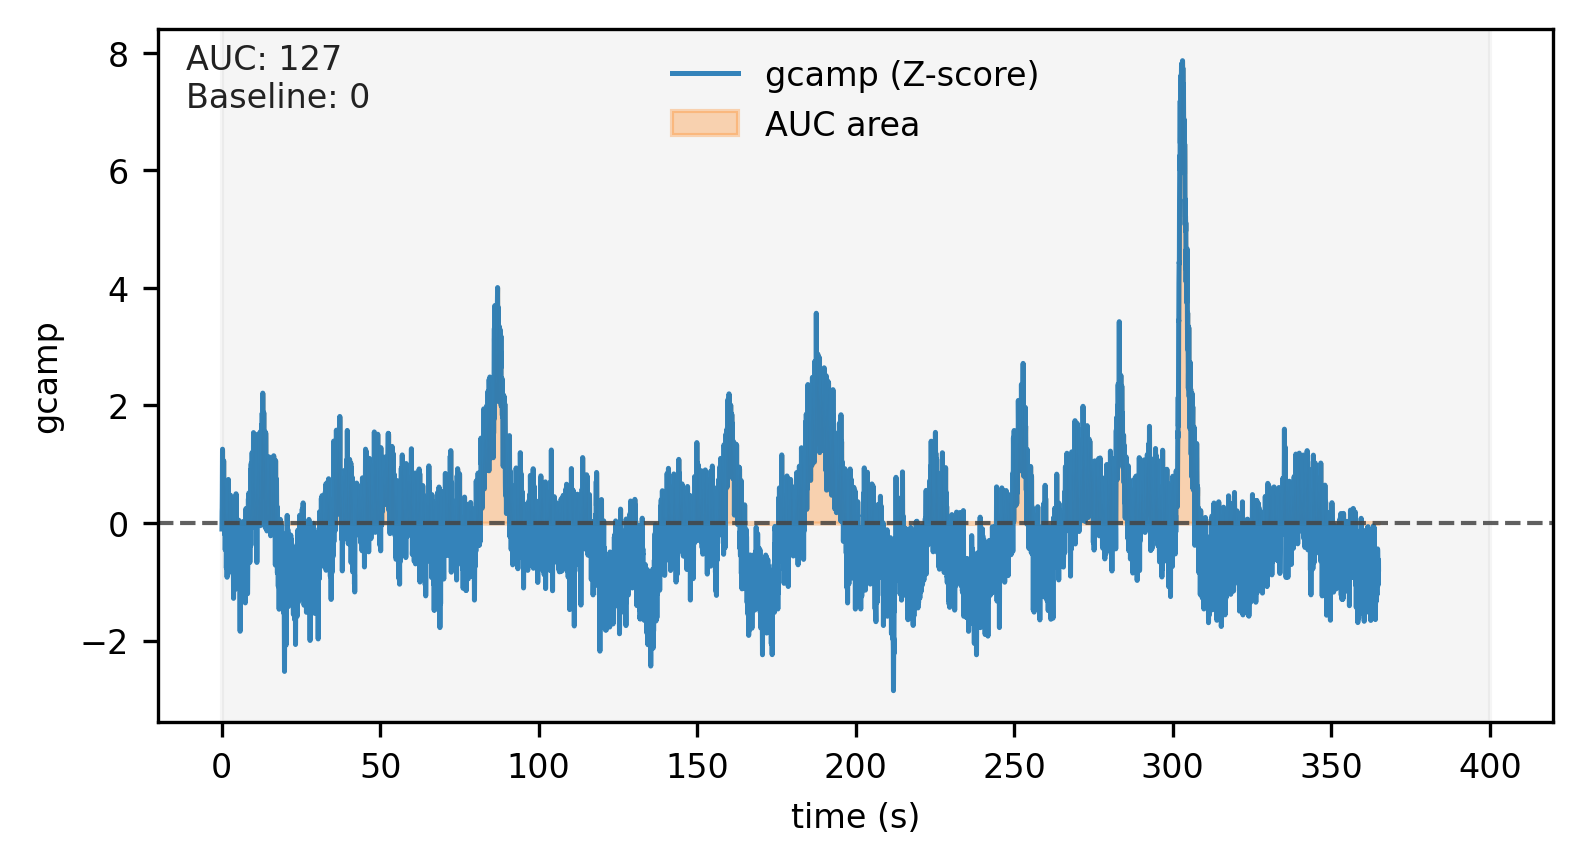

In [4]:
res_zero = AUC(
    signal="gcamp",
    window=AnalysisWindow(0, 400, ref="seconds", label="0–400 s"),
    mode="positive",
    baseline="zero",
    pre_seconds=10.0,
)(state_final)

fig, ax = plot_auc_result(report.state, res_zero, label="gcamp (Z-score)")
plt.show()

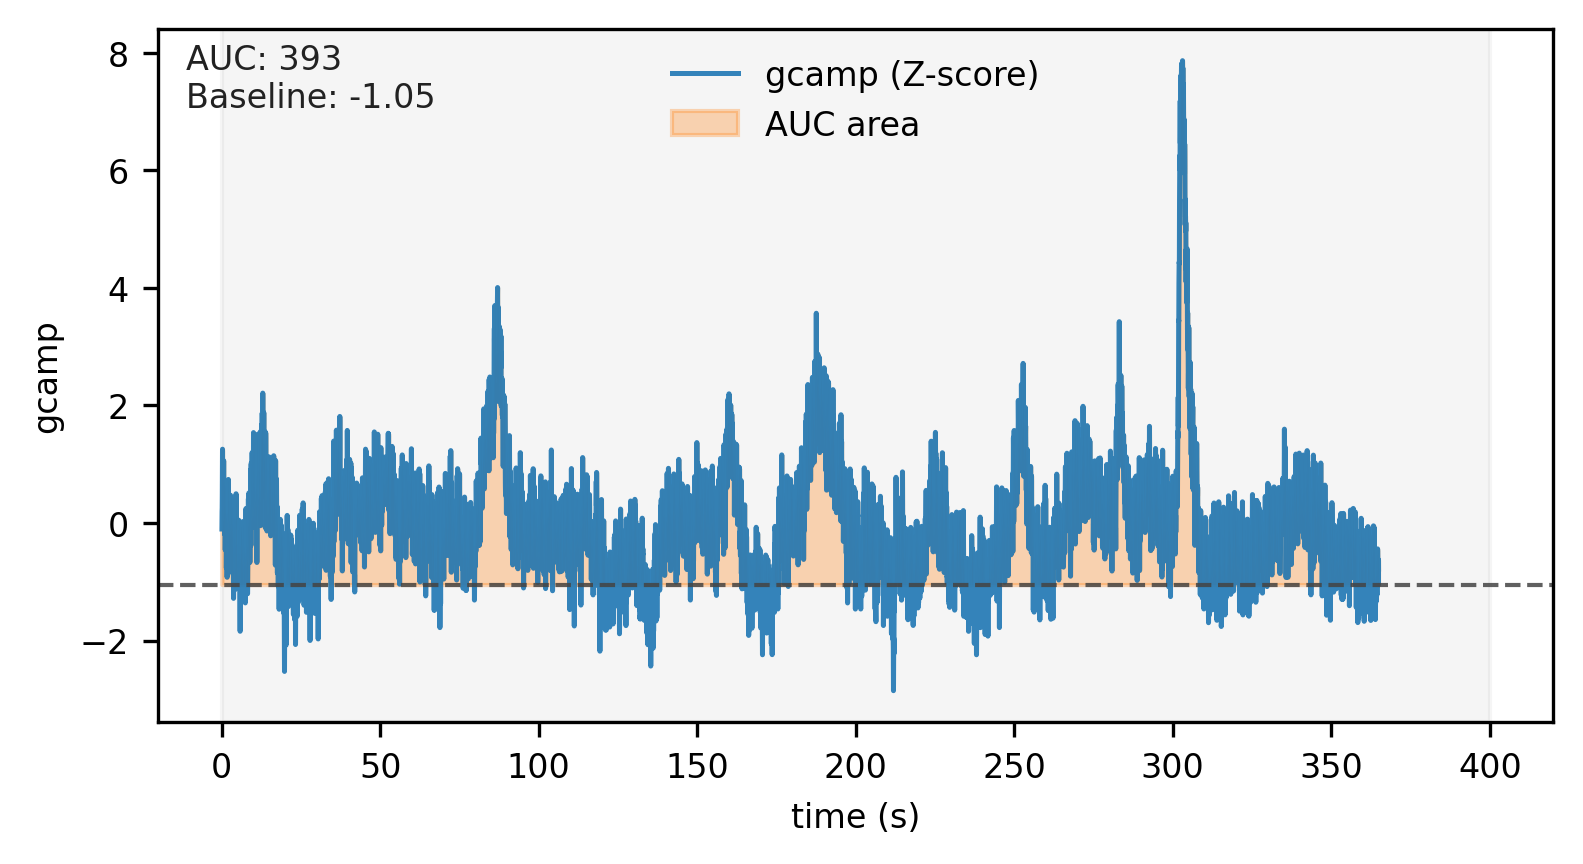

In [5]:
res_quantile = AUC(
    signal="gcamp",
    window=AnalysisWindow(0, 400, ref="seconds", label="0–400 s"),
    mode="positive",
    baseline="pre_quantile",
    pre_seconds=1.0,
)(state_final)

fig, ax = plot_auc_result(report.state, res_quantile, label="gcamp (Z-score)")
plt.show()

In [6]:
report = report.add(res_zero)

---
## Peak finding

,kind,index,x,y,prominence,left_base_index,right_base_index,height,fwhm,left_ip,right_ip,rise_s,decay_s,area,fit_success,fit_r2,fit_rmse,fit_model,fit_params
0,peak,772,12.911729,1.328334,2.817723,445,1188,3.114795,2.219676,12.127196,14.346872,1.7596,4.0172,26.149759,True,0.104260,0.467265,alpha,"(1.3153161590864269, 12.969999501369795, 0.015..."
1,peak,2203,36.666329,1.234183,2.208655,1188,2521,2.529448,2.640503,35.232474,37.872977,0.7470,1.1952,31.015801,True,0.178231,0.377224,alpha,"(0.5744656403585575, 36.50631793260839, 0.1412..."
2,peak,3160,52.552529,1.526872,2.804924,1188,4138,3.023853,4.956855,50.034140,54.990994,2.3738,0.5312,83.726711,True,0.234000,0.300280,alpha,"(0.7806610779123627, 52.48838413719099, 0.0551..."
3,peak,3598,59.823329,0.984917,1.525080,3361,4138,1.552891,1.949736,58.089147,60.038882,0.1992,0.1826,8.440350,True,0.240705,0.342153,alpha,"(1.070920500913485, 59.797653348817605, 0.0379..."
4,peak,5233,86.964329,3.631877,5.500856,1188,12761,6.155391,7.184258,82.304253,89.488510,4.6978,2.5730,492.553432,True,0.253215,0.346043,alpha,"(0.9954506527202589, 86.95023762170285, 0.0492..."


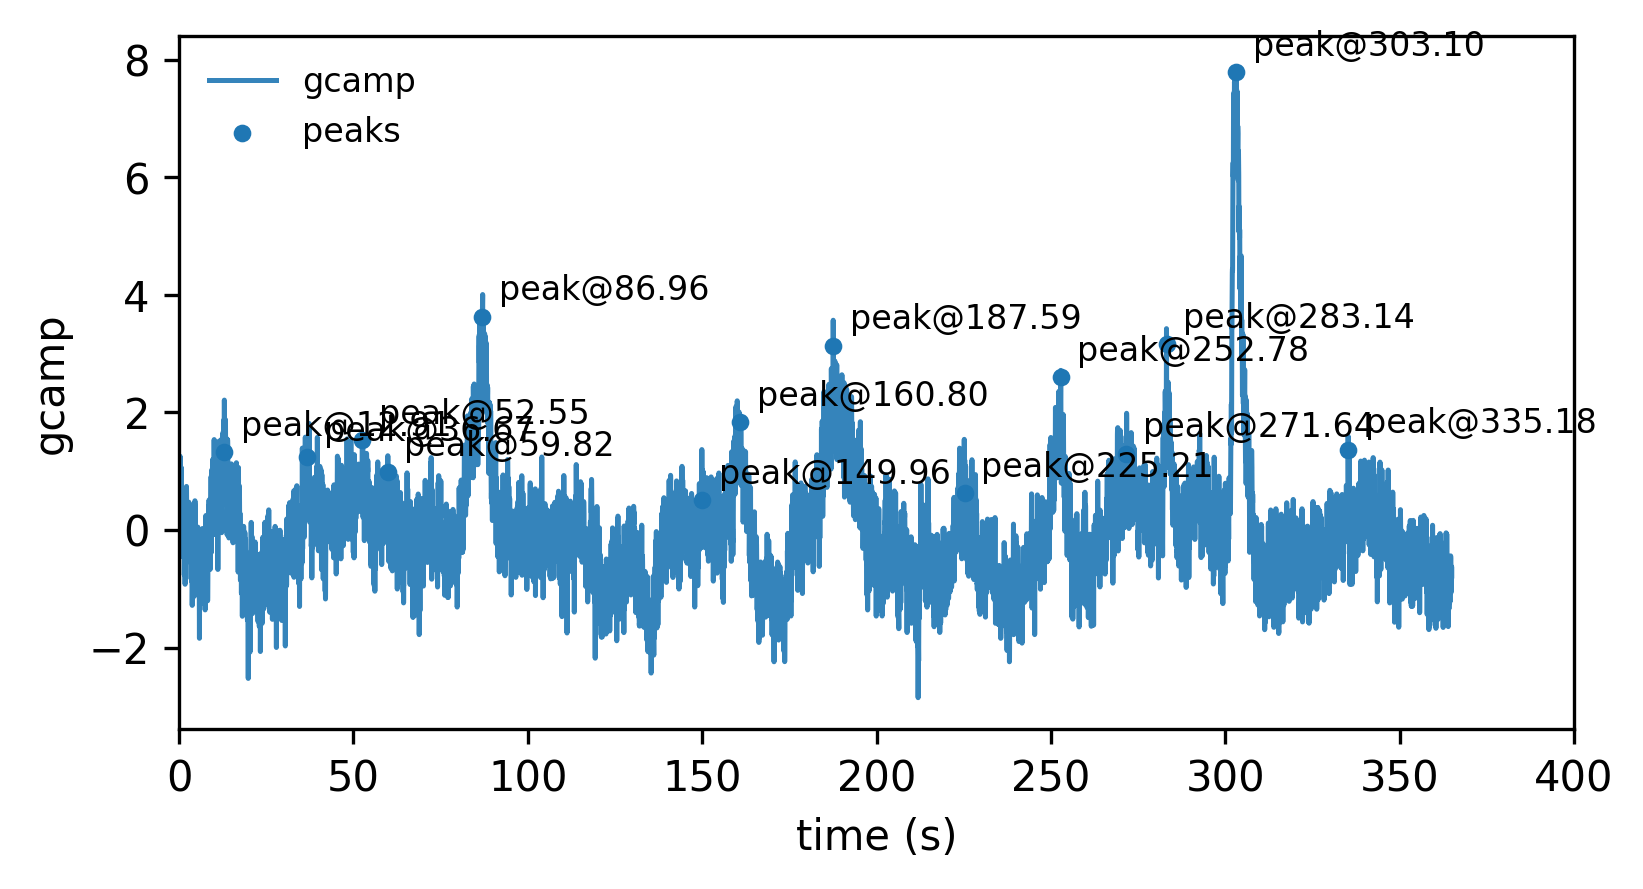

In [7]:
win = AnalysisWindow(start=0, end=400.0, ref="seconds", label="full-trace")


analysis = PeakAnalysis(
    signal="gcamp",
    kind="peak",
    window=win,

    # robustify detection:
    smooth_for_detection=True,
    smooth_method="savgol",        # or "savgol" / "kalman"
    smooth_window_len=25,
    smooth_window="flat",
    smooth_pad_mode="reflect",

    # auto thresholds based on MAD(y_det):
    height=None,
    prominence=None,
    auto_height_sigmas=1.0,
    auto_prominence_sigmas=2.0,

    # reject silly peaks:
    distance_s=0.25, # enforce refractory period (seconds)
    width_s=0.8,     # minimum width (seconds)

    # measurement choices:
    baseline_mode="line",
    area_region="bases",
    rel_height=0.5,

    # asymmetric-friendly peak fits:
    fit_model="alpha", # set None to disable fits
    fit_window_s=2.0,
)

res = analysis(state_final)

df = peak_result_to_dataframe(res)
display(df.head())

fig, ax = plot_peak_result(
    state_final,
    res,
    label="gcamp",
    show_window=False,
    show_bases=False,
    show_fwhm=False,
    annotate=True,
)
ax.set_xlim(win.start, win.end)
plt.show()

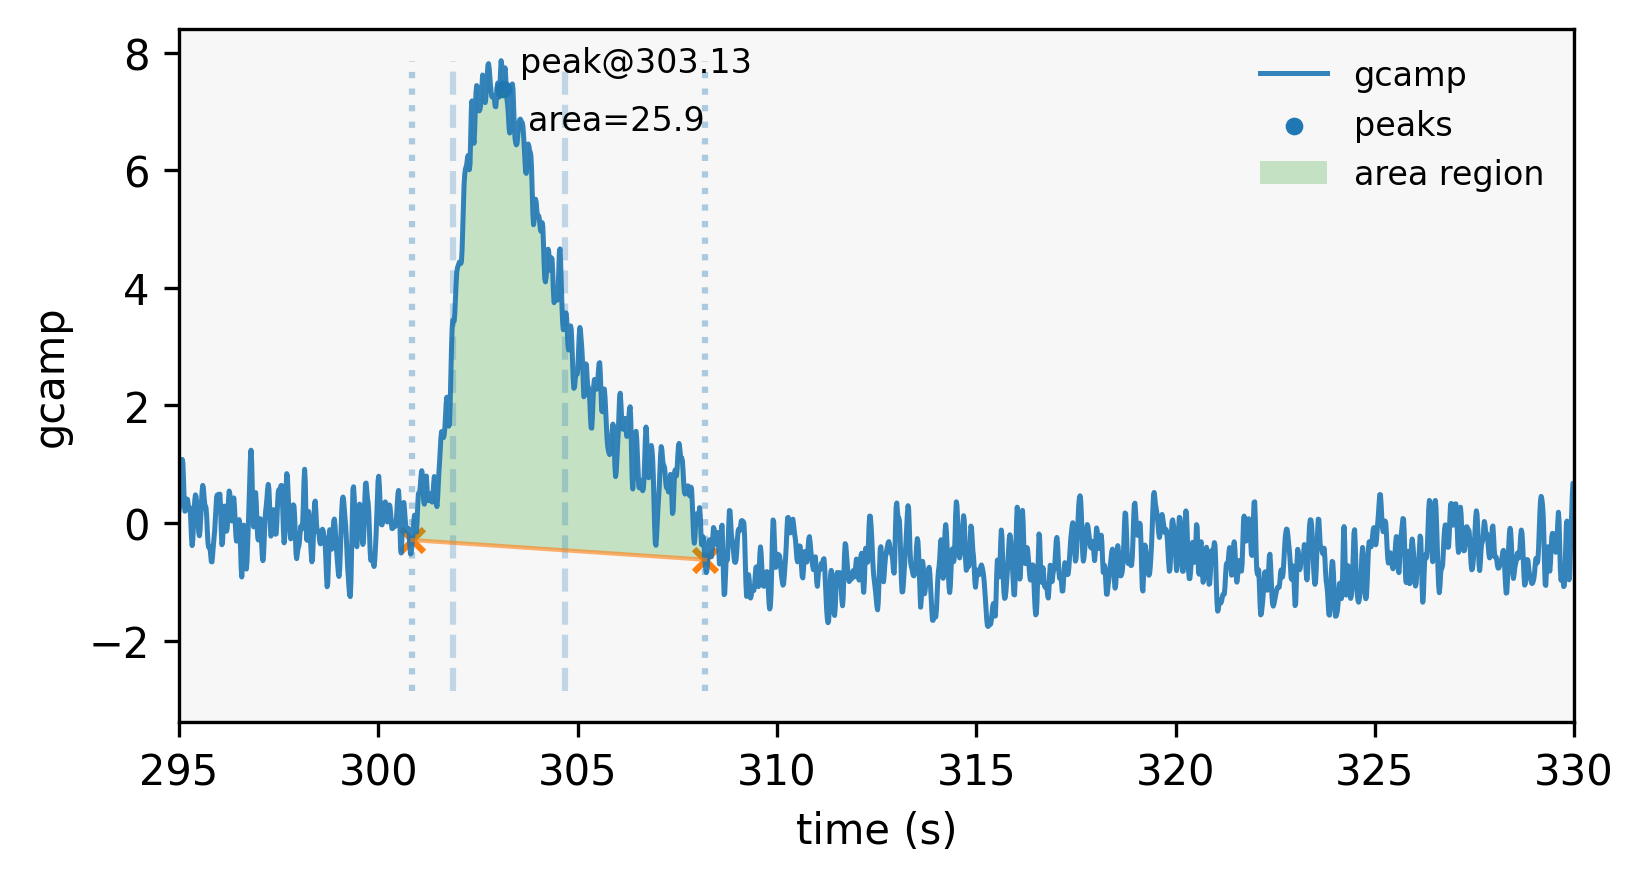

In [8]:
win = AnalysisWindow(start=295, end=330.0, ref="seconds", label="shock")

analysis = PeakAnalysis(
    signal="gcamp",
    kind="peak",
    window=win,
    smooth_for_detection=True,
    smooth_method="savgol",
    smooth_window_len=15,
    height=None,
    prominence=None,
    auto_height_sigmas=1.0,
    auto_prominence_sigmas=2.0,
    distance_s=0.25,
    width_s=0.8,
    baseline_mode="line",
    area_region="bases",
    rel_height=0.5,

    # key change:
    edge_method="fraction",
    edge_fraction=0.10,

    fit_model="alpha",
    fit_window_s=2.0,
)

res = analysis(state_final)

fig, ax = plot_peak_result(
    state_final,
    res,
    label="gcamp",
    show_bases=True,
    show_fwhm=True,
    show_area=True,
    area_event=0,
    annotate=True,
)
ax.set_xlim(win.start, win.end)
plt.show()